<a href="https://colab.research.google.com/github/disty01/Capstone-Project/blob/main/Capstone%20Project_Adristi_Putri_Kisi_Aurellia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain_community
!pip install replicate

## Import Dataset

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata
import os
import re
import string
from tqdm import tqdm

In [42]:
from google.colab import userdata
import os

api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token

In [43]:
from langchain_community.llms import Replicate

# Ambil granite dari replicate
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"max_new_tokens": 10, "temperature": 0}
)

In [44]:
df = pd.read_csv('mobile2025.csv')
df.head()

,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,user_gender,app_version
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,65,14.0,China,Female,1.4
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,209,18.0,Germany,Male,8.9
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,163,67.0,Nigeria,Male,2.8.37.5926
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,664,66.0,India,Female,10.2
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,1197,40.0,South Korea,Prefer not to say,4.7


## Data Understanding

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          2514 non-null   int64  
 1   user_id            2514 non-null   int64  
 2   app_name           2514 non-null   object 
 3   app_category       2514 non-null   object 
 4   review_text        2455 non-null   object 
 5   review_language    2514 non-null   object 
 6   rating             2477 non-null   float64
 7   review_date        2514 non-null   object 
 8   verified_purchase  2514 non-null   bool   
 9   device_type        2514 non-null   object 
 10  num_helpful_votes  2514 non-null   int64  
 11  user_age           2514 non-null   float64
 12  user_country       2473 non-null   object 
 13  user_gender        1927 non-null   object 
 14  app_version        2484 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage: 277.6+ KB


In [46]:
def summarize_features(df):
    # tipe data
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    # jumlah missing value
    summary['Missing'] = df.isnull().sum().values
    # jumlah unique value
    summary['Uniques'] = df.nunique().values

    return summary
summarize_features(df)

,index,dtypes,Missing,Uniques
0,review_id,int64,0,2514
1,user_id,int64,0,2514
2,app_name,object,0,41
3,app_category,object,0,18
4,review_text,object,59,739
5,review_language,object,0,24
6,rating,float64,37,41
7,review_date,object,0,2514
8,verified_purchase,bool,0,2
9,device_type,object,0,5


## Data Preparation

In [47]:
#delete unused in data
df.drop(['user_gender'], axis=1, inplace=True)

In [48]:
# Handling missing value
# "review_text" -> Isi dengan modus
df["review_text"] = df["review_text"].fillna(df["review_text"].value_counts().index[0])
# "user_country" -> Isi dengan modus
df["user_country"] = df["user_country"].fillna(df["user_country"].value_counts().index[0])
# "app_version" -> Isi dengan modus
df["app_version"] = df["app_version"].fillna(df["app_version"].value_counts().index[0])
# "rating" -> Isi dengan median
df["rating"].fillna(df["rating"].median(), inplace = True)
summarize_features(df)

/tmp/ipython-input-2763020116.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["rating"].fillna(df["rating"].median(), inplace = True)


,index,dtypes,Missing,Uniques
0,review_id,int64,0,2514
1,user_id,int64,0,2514
2,app_name,object,0,41
3,app_category,object,0,18
4,review_text,object,0,739
5,review_language,object,0,24
6,rating,float64,0,41
7,review_date,object,0,2514
8,verified_purchase,bool,0,2
9,device_type,object,0,5


In [49]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # hapus link
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)         # hapus mention
    text = re.sub(r'#', '', text)                      # hapus tanda #
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip()           # hapus spasi berlebih
    return text

df['cleaned_text'] = df['review_text'].apply(clean_text)

print("\nContoh teks setelah dibersihkan:")
print(df[['review_text', 'cleaned_text']].head())


Contoh teks setelah dibersihkan:
                                         review_text  \
0  Qui doloribus consequuntur. Perspiciatis tempo...   
1  Great app but too many ads, consider premium v...   
2  The interface could be better but overall good...   
3  Latest update broke some features, please fix ...   
4  Perfect for daily use, highly recommend to eve...   

                                        cleaned_text  
0  qui doloribus consequuntur perspiciatis tempor...  
1  great app but too many ads consider premium ve...  
2  the interface could be better but overall good...  
3  latest update broke some features please fix soon  
4  perfect for daily use highly recommend to ever...  


## Sentiment Analysis

In [50]:
def classify_sentiment(text):
    prompt = f"""
    Klasifikasikan ulasan berikut sebagai 'Positif', 'Negatif', atau 'Netral'.
    Berikan hanya satu kata.
    Ulasan: "{text}"
    Sentimen:
    """
    try:
        result = llm(prompt).strip().lower()
        if "positif" in result:
            return "Positif"
        elif "negatif" in result:
            return "Negatif"
        elif "netral" in result:
            return "Netral"
        else:
            return "Tidak Terdeteksi"
    except Exception as e:
        return f"ERROR: {e}"

In [51]:
tqdm.pandas(desc="Menganalisis Sentimen")
df["sentiment"] = df["cleaned_text"].progress_apply(classify_sentiment)

Menganalisis Sentimen: 100%|██████████| 2514/2514 [27:10<00:00,  1.54it/s]


In [52]:
print("\nContoh hasil klasifikasi (10 data pertama):")
print(df[["review_text", "sentiment"]].head(10))

print("\nRingkasan jumlah sentimen:")
print(df["sentiment"].value_counts())


Contoh hasil klasifikasi (10 data pertama):
                                         review_text sentiment
0  Qui doloribus consequuntur. Perspiciatis tempo...   Negatif
1  Great app but too many ads, consider premium v...   Positif
2  The interface could be better but overall good...    Netral
3  Latest update broke some features, please fix ...   Negatif
4  Perfect for daily use, highly recommend to eve...   Positif
5  Works perfectly on my device, no complaints at...   Positif
6  Basso bello società paese. Quello mostrare verso.    Netral
7  Odcinek skład zarówno zgodnie zaś. Powoli gdyb...    Netral
8  Eius odio facilis fuga distinctio eaque. Non c...   Negatif
9       Husband at tree note responsibility defense.    Netral

Ringkasan jumlah sentimen:
sentiment
Positif    1182
Netral      692
Negatif     640
Name: count, dtype: int64


In [58]:
df.head()

,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,app_version,cleaned_text,sentiment
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,65,14.0,China,1.4,qui doloribus consequuntur perspiciatis tempor...,Negatif
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,209,18.0,Germany,8.9,great app but too many ads consider premium ve...,Positif
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,163,67.0,Nigeria,2.8.37.5926,the interface could be better but overall good...,Netral
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,664,66.0,India,10.2,latest update broke some features please fix soon,Negatif
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,1197,40.0,South Korea,4.7,perfect for daily use highly recommend to ever...,Positif


## Exploratory Data Analysis (EDA)



/tmp/ipython-input-722894759.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, order=df["sentiment"].value_counts().index,


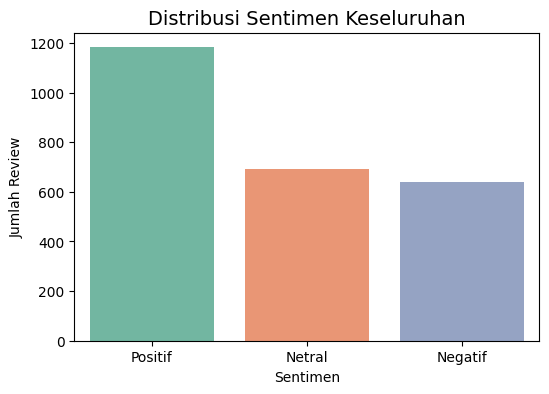

In [59]:
# Sentiment Distribution
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df, order=df["sentiment"].value_counts().index,
              palette="Set2")
plt.title("Distribusi Sentimen Keseluruhan", fontsize=14)
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

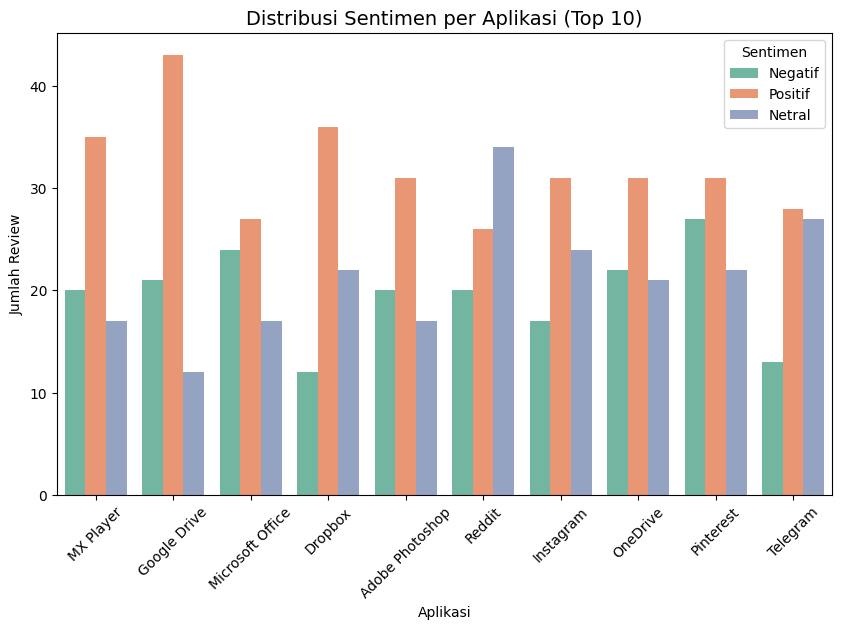

In [64]:
# Sentiment per Application
plt.figure(figsize=(10,6))
app_order = df["app_name"].value_counts().index[:10]   # ambil 10 app teratas
sns.countplot(x="app_name", hue="sentiment",
              data=df[df["app_name"].isin(app_order)],
              palette="Set2")
plt.title("Distribusi Sentimen per Aplikasi (Top 10)", fontsize=14)
plt.xlabel("Aplikasi")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=45)
plt.legend(title="Sentimen")
plt.show()

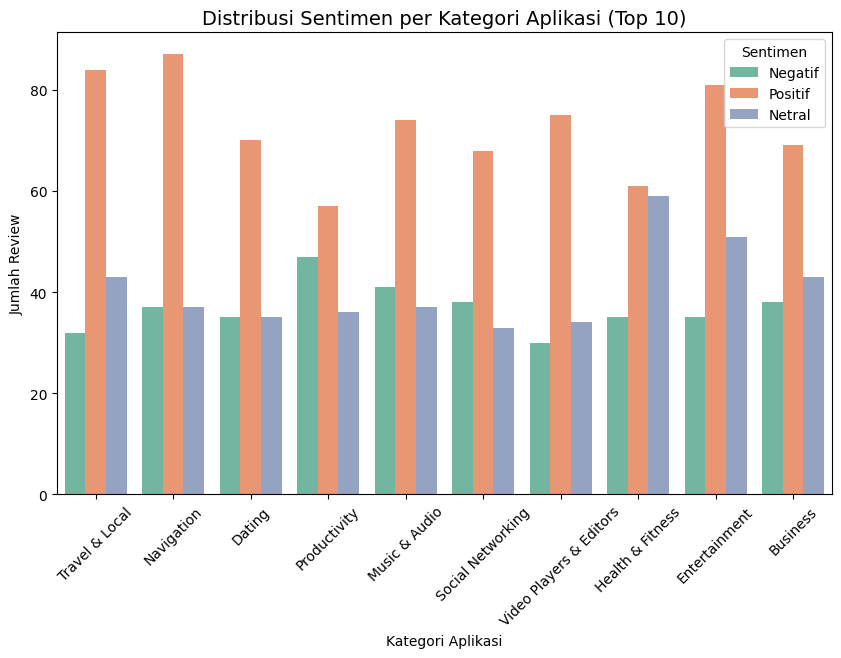

In [89]:
# Sentiment Distribution by App Category
if "app_category" in df.columns:
    plt.figure(figsize=(10,6))
    cat_order = df["app_category"].value_counts().index[:10]
    sns.countplot(x="app_category", hue="sentiment",
                  data=df[df["app_category"].isin(cat_order)],
                  palette="Set2")
    plt.title("Distribusi Sentimen per Kategori Aplikasi (Top 10)", fontsize=14)
    plt.xlabel("Kategori Aplikasi")
    plt.ylabel("Jumlah Review")
    plt.xticks(rotation=45)
    plt.legend(title="Sentimen")
    plt.show()

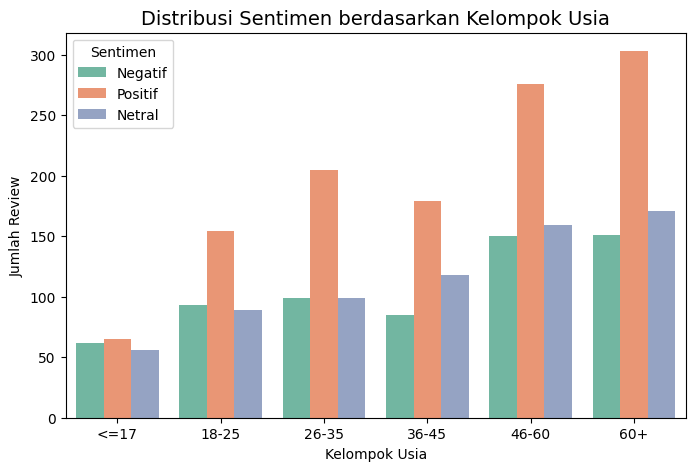

In [66]:
# Sentiment Distribution by Age Group
if "user_age" in df.columns:
    bins = [0,17,25,35,45,60,120]
    labels = ["<=17","18-25","26-35","36-45","46-60","60+"]
    df["age_group"] = pd.cut(df["user_age"], bins=bins, labels=labels, right=True)

    plt.figure(figsize=(8,5))
    sns.countplot(x="age_group", hue="sentiment", data=df, palette="Set2")
    plt.title("Distribusi Sentimen berdasarkan Kelompok Usia", fontsize=14)
    plt.xlabel("Kelompok Usia")
    plt.ylabel("Jumlah Review")
    plt.legend(title="Sentimen")
    plt.show()

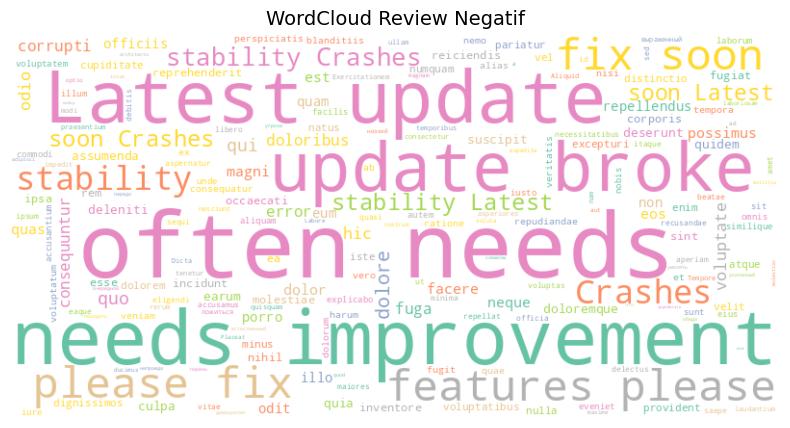

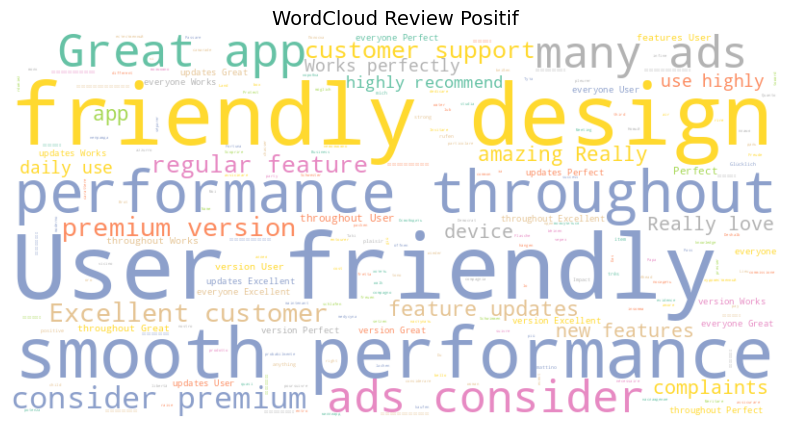

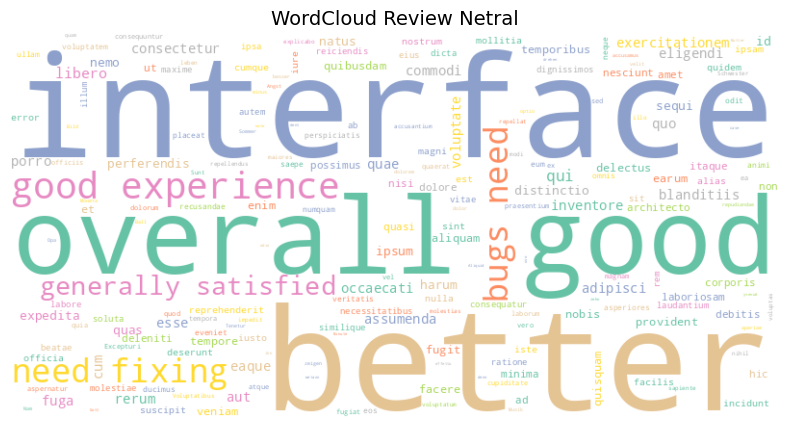

In [68]:
# WordCloud for review
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
for sentiment_label in df["sentiment"].unique():
    text = " ".join(review for review in df[df["sentiment"]==sentiment_label]["review_text"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords,
                          colormap="Set2").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud Review {sentiment_label.capitalize()}", fontsize=14)
    plt.show()

In [73]:
#Top words per sentiment (unigrams)
from sklearn.feature_extraction.text import CountVectorizer
def top_n_words(corpus, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).flatten()
    terms = np.array(vec.get_feature_names_out())
    top_idx = np.argsort(sums)[::-1][:n]
    return list(zip(terms[top_idx], sums[top_idx]))

for s in ["Positif", "Negatif", "Netral"]:
    subset = df[df["sentiment"]==s]["cleaned_text"]
    if subset.shape[0] > 0:
        print(f"\nTop unigrams for {s} (count={subset.shape[0]}):")
        print(top_n_words(subset, n=15, ngram_range=(1,1)))
        print(f"Top bigrams for {s}:")
        print(top_n_words(subset, n=10, ngram_range=(2,2)))


Top unigrams for Positif (count=1182):
[('app', np.int64(358)), ('userfriendly', np.int64(253)), ('performance', np.int64(253)), ('design', np.int64(253)), ('smooth', np.int64(253)), ('ads', np.int64(189)), ('premium', np.int64(189)), ('great', np.int64(189)), ('version', np.int64(189)), ('consider', np.int64(189)), ('updates', np.int64(186)), ('excellent', np.int64(186)), ('regular', np.int64(186)), ('customer', np.int64(186)), ('feature', np.int64(186))]
Top bigrams for Positif:
[('design smooth', np.int64(253)), ('userfriendly design', np.int64(253)), ('smooth performance', np.int64(253)), ('consider premium', np.int64(189)), ('premium version', np.int64(189)), ('great app', np.int64(189)), ('ads consider', np.int64(189)), ('app ads', np.int64(189)), ('feature updates', np.int64(186)), ('regular feature', np.int64(186))]

Top unigrams for Negatif (count=640):
[('crashes', np.int64(181)), ('stability', np.int64(181)), ('needs', np.int64(181)), ('improvement', np.int64(181)), ('fix',

In [74]:
# Hitung persentase review positif tiap app
sentiment_summary = (
    df.groupby("app_name")["sentiment"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

# Ambil hanya yang 'Positif'
positive_summary = sentiment_summary[sentiment_summary["sentiment"] == "Positif"]

# Urutkan dari yang terbaik
top_apps = positive_summary.sort_values(by="proportion", ascending=False)

print("\n📊 App dengan review paling positif:")
print(top_apps.head(10))


📊 App dengan review paling positif:
         app_name sentiment  proportion
45   Khan Academy   Positif    0.629630
60        Netflix   Positif    0.580645
102           VLC   Positif    0.571429
33   Google Drive   Positif    0.565789
93        Twitter   Positif    0.559322
90         Tinder   Positif    0.548387
87         TikTok   Positif    0.539683
21        Discord   Positif    0.522727
105         Venmo   Positif    0.520000
30       Facebook   Positif    0.519231


<Figure size 1000x600 with 0 Axes>

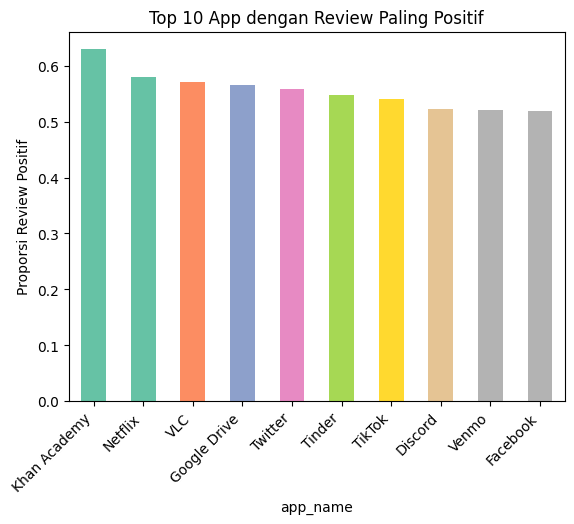

In [78]:
import matplotlib.cm as cm
plt.figure(figsize=(10,6))

# ambil 10 app teratas
top10 = top_apps.head(10)

# buat warna berbeda untuk tiap bar
colors = cm.Set2(np.linspace(0, 1, len(top10)))

top10.plot(
    kind="bar",
    x="app_name",
    y="proportion",
    legend=False,
    color=colors
)

plt.title("Top 10 App dengan Review Paling Positif")
plt.ylabel("Proporsi Review Positif")
plt.xticks(rotation=45, ha="right")
plt.show()

In [88]:
print("\n📝 Contoh review positif dari app terbaik:\n")
for app in top_apps.head(5)["app_name"]:  # ambil 5 app terbaik
    reviews = df[(df["app_name"] == app) & (df["sentiment"] == "Positif")]
    print(f"=== {app} ===")
    for review in reviews["review_text"].head(3):  # tampilkan 3 review pertama
        print("-", review)
    print()


📝 Contoh review positif dari app terbaik:

=== Khan Academy ===
- Great app but too many ads, consider premium version.
- This app is amazing! Really love the new features.
- Works perfectly on my device, no complaints at all.

=== Netflix ===
- Works perfectly on my device, no complaints at all.
- User-friendly design and smooth performance throughout.
- User-friendly design and smooth performance throughout.

=== VLC ===
- User-friendly design and smooth performance throughout.
- Great app but too many ads, consider premium version.
- Great app but too many ads, consider premium version.

=== Google Drive ===
- Perfect for daily use, highly recommend to everyone.
- This app is amazing! Really love the new features.
- User-friendly design and smooth performance throughout.

=== Twitter ===
- User-friendly design and smooth performance throughout.
- Great app but too many ads, consider premium version.
- User-friendly design and smooth performance throughout.



In [79]:
# Hitung proporsi review negatif tiap app
sentiment_summary = (
    df.groupby("app_name")["sentiment"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

# Ambil hanya yang 'Negatif'
negative_summary = sentiment_summary[sentiment_summary["sentiment"] == "Negatif"]

# Urutkan dari yang paling buruk
worst_apps = negative_summary.sort_values(by="proportion", ascending=False)

print("\n📊 App dengan review paling negatif:")
print(worst_apps.head(10))


📊 App dengan review paling negatif:
             app_name sentiment  proportion
40          Grammarly   Negatif    0.378788
121              eBay   Negatif    0.368421
58   Microsoft Office   Negatif    0.352941
49           LinkedIn   Negatif    0.339286
70          Pinterest   Negatif    0.337500
28           Duolingo   Negatif    0.333333
16              Canva   Negatif    0.333333
13             Bumble   Negatif    0.303571
64           OneDrive   Negatif    0.297297
1     Adobe Photoshop   Negatif    0.294118


<Figure size 1000x600 with 0 Axes>

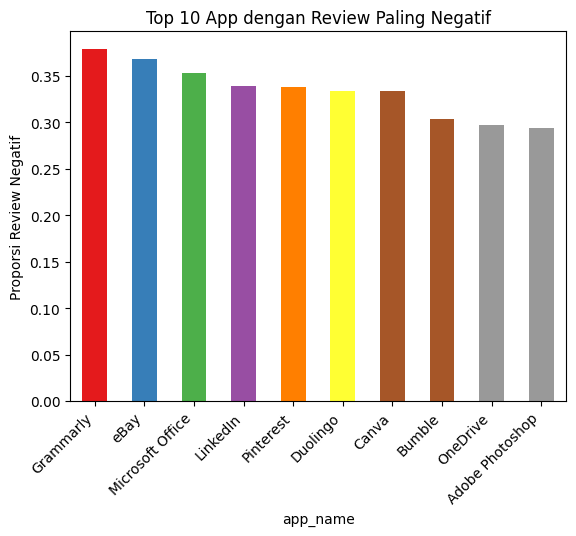

In [80]:
import matplotlib.cm as cm
# --- Filter app dengan proporsi review negatif ---
top_neg = (
    sentiment_summary[sentiment_summary["sentiment"]=="Negatif"]
    .sort_values("proportion", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))

# buat warna berbeda tiap app
colors = cm.Set1(np.linspace(0, 1, len(top_neg)))

top_neg.plot(
    kind="bar",
    x="app_name",
    y="proportion",
    legend=False,
    color=colors
)

plt.title("Top 10 App dengan Review Paling Negatif")
plt.ylabel("Proporsi Review Negatif")
plt.xticks(rotation=45, ha="right")
plt.show()

In [83]:
!pip install deep-translator --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.3 MB/s eta 0:00:00


In [84]:
from deep_translator import GoogleTranslator

# Translator dari auto-detect -> English
translator = GoogleTranslator(source="auto", target="en")

print("\n📝 Contoh review negatif dari app terburuk (diterjemahkan):\n")
for app in worst_apps.head(5)["app_name"]:   # ambil 5 app terburuk
    reviews = df[(df["app_name"] == app) & (df["sentiment"] == "Negatif")]
    print(f"=== {app} ===")
    for review in reviews["review_text"].head(3):   # tampilkan 3 review pertama
        try:
            translated = translator.translate(review)
        except Exception as e:
            translated = review  # fallback kalau error
        print(f"- {review}")
        print(f"  👉 (Translated): {translated}")
    print()


📝 Contoh review negatif dari app terburuk (diterjemahkan):

=== Grammarly ===
- Stupido malattia donna magari già posare sbagliare qualità. Tempo vino morale sviluppo ora popolazione avvicinare.
  👉 (Translated): Stupid woman's disease maybe already lay wrong quality. Time moral wine development now population approach.
- Crashes too often, needs improvement in stability.
  👉 (Translated): Crashes too often, needs improvement in stability.
- Сынок факультет ягода миллиард провал. Монета экзамен более неожиданно самостоятельно вскакивать покидать.
  👉 (Translated): Son Faculty of Berry Billion failure. Coin to the exam more unexpected to jump away on their own.

=== eBay ===
- Latest update broke some features, please fix soon.
  👉 (Translated): Latest update broke some features, please fix soon.
- Voluptas quis magni autem numquam. Non corrupti quis molestiae quod minus a.
  👉 (Translated): The pleasure who is great but never. Not corrupt any discomfort is less than a.
- Crashes too o

## Insight

**Overall Sentiment Distribution**
- Majority of reviews are Positive (47%)
- Negative reviews (25%) concentrated in apps with performance or UX issues
- Neutral reviews (28%) are often short or factual

**Top Apps by Sentiment**
- Positive: Khan Academy, Netflix, VLC, Google Drive and other entertainment apps
- Negative: Grammarly, Ebay, Microsoft Office and other. Often due to crashes or slow performance

**Sentiment by App Category**
- Navigation & entertainment apps: High positive review rates
- Productivity apps: More negative reviews (technical issues, complexity)

**Sentiment by Demographics**
- Age 18–35: Not too many reviews
- Age >45: Frequently provide both positive and negative reviews

**Text Analysis**
- Positive keywords: userfriendly, design, smooth
- Negative keywords: crashes, improvement, update
- Neutral keywords: better overall, good, interface

## Recommendation

**1. Fix High Negative Apps**
  - Problem: Apps like Grammarly, eBay, Microsoft Office → frequent crashes & slow performance

  - Action:
    - Identify and fix critical bugs
    - Optimize loading and responsiveness
    - Perform regression testing after updates

Impact: Reduce negative reviews, improve user satisfaction

**2. UX & UI Improvement**
- Problem: Productivity apps are complex & not intuitive
- Action:
  - Simplify navigation and features
  - Add tutorials or guided modes
  - Test design changes with users >45 years old

Impact: Reduce user frustration, increase positive feedback

**3. Enhance Positive Features**
- Problem: Positive apps like Khan Academy, Netflix, VLC, Google Drive → maintain strengths
- Action:
  - Preserve smooth, user-friendly experience
  - Enhance features aligned with keywords: userfriendly, design, smooth

Impact: Retain loyal users, encourage more positive review

**4. Monitor Negative Keywords**
- Problem: Reviews mention crashes, improvement, update
- Action:
  - Build dashboard to track negative keywords
  - Early warning system for technical issues

Impact: Quickly detect and resolve problems before affecting more users


**5. Update Quality Assurance**
- Problem: Negative reviews post-update (update)
- Action:
  - Perform strict QA before updates
  - Provide clear changelog & update notifications

Impact: Minimize user confusion and complaints, maintain app reputation